In [3]:
import os
import json

import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

Data Collection 

In [43]:
kaggle_config = json.load(open('kaggle.json'))
kaggle_config.keys()

# Setup the environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
os.environ['KAGGLE_KEY'] = kaggle_config['key']


In [13]:
!kaggle datasets download notshrirang/spotify-million-song-dataset
!ls

Dataset URL: https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset
License(s): CC0-1.0
spotify-million-song-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
kaggle.json  music-recom.ipynb	spotify-million-song-dataset.zip  venv


In [86]:
with zipfile.ZipFile('spotify-million-song-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()
df = pd.read_csv("spotify_millsongdata.csv")
df

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...
...,...,...,...,...
57645,Ziggy Marley,Good Old Days,/z/ziggy+marley/good+old+days_10198588.html,Irie days come on play \r\nLet the angels fly...
57646,Ziggy Marley,Hand To Mouth,/z/ziggy+marley/hand+to+mouth_20531167.html,Power to the workers \r\nMore power \r\nPowe...
57647,Zwan,Come With Me,/z/zwan/come+with+me_20148981.html,all you need \r\nis something i'll believe \...
57648,Zwan,Desire,/z/zwan/desire_20148986.html,northern star \r\nam i frightened \r\nwhere ...


Understanding/Visualizing

In [87]:
df.shape
df.head()
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


artist    0
song      0
link      0
text      0
dtype: int64

In [88]:
# Top few artists/songs
top_artist = df['artist'].value_counts().head(10)
print("\nTop 10 Artists:")
print(top_artist)
df


Top 10 Artists:
artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Alabama             187
Reba Mcentire       187
Cher                187
Loretta Lynn        187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...
...,...,...,...,...
57645,Ziggy Marley,Good Old Days,/z/ziggy+marley/good+old+days_10198588.html,Irie days come on play \r\nLet the angels fly...
57646,Ziggy Marley,Hand To Mouth,/z/ziggy+marley/hand+to+mouth_20531167.html,Power to the workers \r\nMore power \r\nPowe...
57647,Zwan,Come With Me,/z/zwan/come+with+me_20148981.html,all you need \r\nis something i'll believe \...
57648,Zwan,Desire,/z/zwan/desire_20148986.html,northern star \r\nam i frightened \r\nwhere ...


In [101]:
df = df.sample(20000)
df

,artist,song,link,text,cleaned_text
48511,Pitbull,Oye Baby,/p/pitbull/oye+baby_20915414.html,nicola fasano hope said right mr three five be...,nicola fasano hope said right mr three five be...
10572,Kim Wilde,Janine,/k/kim+wilde/janine_20078501.html,janine whats going janine know something sure ...,janine whats going janine know something sure ...
4157,Devo,Disco Dancer,/d/devo/disco+dancer_20039658.html,im disco dancer ive got place go im disco boy ...,im disco dancer ive got place go im disco boy ...
54103,U. D. O.,Shout It Out,/u/u+d+o/shout+it+out_20141335.html,frightened getting mood body breaking volume l...,frightened getting mood body breaking volume l...
4903,Elton John,Island Girl,/e/elton+john/island+girl_20046885.html,see teeth flash jamaican honey sweet lexington...,see teeth flash jamaican honey sweet lexington...
...,...,...,...,...,...
35257,Hank Williams Jr.,Country Music (those Tear Jerking Songs),/h/hank+williams+jr/country+music+those+tear+j...,oh show home back breakin lawn wife nudge nigh...,oh show home back breakin lawn wife nudge nigh...
25749,Blur,You're So Great,/b/blur/youre+so+great_20020999.html,sad drunk poorly sleeping really late sad drun...,sad drunk poorly sleeping really late sad drun...
53276,Tina Turner,All The Woman,/t/tina+turner/all+the+woman_20137675.html,cant see cant see dont walk crowded streets ch...,cant see cant see dont walk crowded streets ch...
4047,Def Leppard,Rock Brigade,/d/def+leppard/rock+brigade_20038926.html,well middle night early morning light hear mil...,well middle night early morning light hear mil...


In [102]:
# WorldCloud for song lyrics
df
all_lyrics = " ".join(df["text"].dropna())
worldcloud = WordCloud(width=800, height=400, background_color="white").generate(all_lyrics)

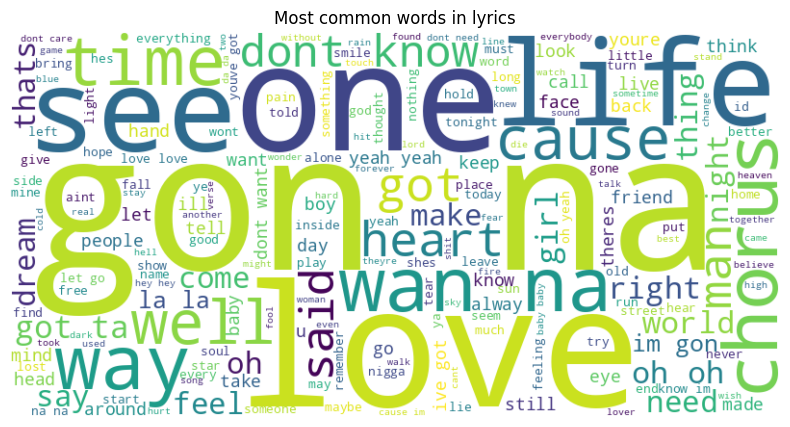

In [103]:
# Plot shows us the most used words in the lyrics
plt.figure(figsize=(10,5))
plt.imshow(worldcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most common words in lyrics")
plt.show()

Data Preprocessing

In [104]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/asoliman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/asoliman/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/asoliman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [105]:
# Creating the stop words dataset
stop_words = set(stopwords.words("english"))

In [106]:
def preprocess_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [107]:
# Apply preprocessing to lyrics
df['cleaned_text'] = df['text'] = df['text'].apply(preprocess_text)

In [108]:
tfidf_vectorizer  = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])
# Complete cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [125]:
# Recomendation function
def recommend_songs(song_name, cosine_sim=cosine_sim, df=df, top_n=5):
    idx = df[df['song'].str.lower() == song_name.lower()].index
    if len(idx) == 0:
        return "Song not in dataset :("
    idx = idx[0]

    # Find similarity scores
    sim_scoores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scoores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    song_indicies = [i[0] for i in sim_scoores]

    return df[['artist', 'song']].iloc[song_indicies]

In [123]:
df['song'][2]

'As Good As New'

In [126]:
#Example recomend
print("\nRecommendations for the song 'Oye Baby':")
recommendations = recommend_songs(song_name="As Good As New")
print(recommendations)


Recommendations for the song 'Oye Baby':
                  artist                                      song
48511            Pitbull                                  Oye Baby
10572          Kim Wilde                                    Janine
4157                Devo                              Disco Dancer
54103           U. D. O.                              Shout It Out
4903          Elton John                               Island Girl
...                  ...                                       ...
35257  Hank Williams Jr.  Country Music (those Tear Jerking Songs)
25749               Blur                           You're So Great
53276        Tina Turner                             All The Woman
4047         Def Leppard                              Rock Brigade
4039         Def Leppard                                Nine Lives

[20000 rows x 2 columns]
